In [232]:
import pandas as pd 
import glob

# read all json files from sagemaker directory into pandas df
df = pd.concat([pd.read_json(f,orient = 'index').transpose() for f in glob.glob('sagemaker/*.json')], ignore_index = True)

print(df.head().to_markdown(index=False))

| Host      | Model Id                 | Instance       |   Tensor parallelism degree | quantization   |   generated_tokens per request | Do Sample   |   Number of requests |   Virtual Users |   Thorughput (tokens/second) |   Latency (ms/token) avg |   Latency (ms/token) min |   Latency (ms/token) med |   Latency (ms/token) max |   Latency (ms/token) p(90) |   Latency (ms/token) p(95) |   Latency Request ms p(90) |   Latency Request ms p(95) |   Latency Request ms avg |   Latency Request ms min |   Latency Request ms med |   Latency Request ms max |   Latency Infernece ms med |   Latency Infernece ms max |   Latency Infernece ms p(90) |   Latency Infernece ms p(95) |   Latency Infernece ms avg |   Latency Infernece ms min |   Queue time ms med |   Queue time ms max |   Queue time ms p(90) |   Queue time ms p(95) |   Queue time ms avg |   Queue time ms min |
|:----------|:-------------------------|:---------------|----------------------------:|:---------------|--------------------------

## Overall Summary

In this benchmarking study, we evaluate the performance of Text Generation Inference (TGIs) for different open LLMs on a variety of hardware configurations and inference settings. The goal is to gain insights into TGIs performance and efficiency and identify the optimal setup for our specific use case.


### Dataset Overview

Our benchmarking dataset consists of several key performance metrics recorded during model inference on different instances and under various conditions. The dataset includes the following columns:

- Host: The name of the hardware host where the inference was executed.
- Model Id: A unique identifier for our deep learning model.
- Instance: The type of instance used for the inference (e.g., CPU, GPU, etc.).
- Tensor Parallelism Degree: The degree of tensor parallelism employed during inference.
- Quantization: The quantization level applied to the model (if any).
- Generated Tokens per Request: The number of tokens generated in each inference request.
- Do Sample: A binary indicator of whether sampling was enabled during inference.
- Number of Requests: The total number of inference requests made during the benchmark.
- Virtual Users: The number of virtual users simulating inference requests.
- Throughput (tokens/second): The average number of tokens processed per second.
- Latency (ms/token) avg: The average latency in milliseconds per token. 
- ... (other latency-related metrics)
- Queue Time (ms): The time spent in the queue before processing.


The full dataset is available in the following Google Sheets or on Hugging Face.


### Payload and Environment 

We used the following setup: 
* Load testing tool `k6`
* TGI version 0.8.2
* hyperparameters were: `max_new_tokens: 50, sample: true, top_p: 0.9, top_k: 50, temperature: 0.2`


## Performance Metrics

For the performance metrics, we will look at two key metrics, Latency and Throughput. We define Latency as the time it takes for one token to be generated. We define Throughput as the number of tokens generated per second. 

For both metrics, we will look at the performance across different models, different instracture setups and compare different platforms. 

### Latency

The Dataset contains different latency metrics including token latency (ms/token), request infernece latency (ms/request), queue time (time spent before beeing processed), request latency (overall e2e latency). We focused on the token latency (ms/token) for our analysis.

In [233]:
ldf = df[['Host', 'Model Id', 'Instance','Virtual Users' ,'Tensor parallelism degree','Latency (ms/token) avg', 'Latency (ms/token) min','Latency (ms/token) med', 'Latency (ms/token) max','Latency (ms/token) p(90)', 'Latency (ms/token) p(95)']]

print(ldf.sort_values(by=['Latency (ms/token) p(95)'], ascending=True).to_markdown(index=False))

| Host      | Model Id                 | Instance        |   Virtual Users |   Tensor parallelism degree |   Latency (ms/token) avg |   Latency (ms/token) min |   Latency (ms/token) med |   Latency (ms/token) max |   Latency (ms/token) p(90) |   Latency (ms/token) p(95) |
|:----------|:-------------------------|:----------------|----------------:|----------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|---------------------------:|---------------------------:|
| sagemaker | meta-llama/Llama-2-7b-hf | ml.p4d.24xlarge |               1 |                           1 |                  15.455  |                  13.4399 |                  14.3924 |                  60.3234 |                    16.3311 |                    16.8196 |
| sagemaker | meta-llama/Llama-2-7b-hf | ml.g5.12xlarge  |               1 |                           4 |                  19.0332 |                  16.1313 |                  17.

In [234]:
vu=1
grouped_data = ldf[ldf['Virtual Users'] == vu][['Model Id', 'Instance', 'Tensor parallelism degree','Latency (ms/token) med',   'Latency (ms/token) p(90)',    'Latency (ms/token) p(95)']]
grouped_data.sort_values(by=['Latency (ms/token) p(95)'], ascending=True)

,Model Id,Instance,Tensor parallelism degree,Latency (ms/token) med,Latency (ms/token) p(90),Latency (ms/token) p(95)
9,meta-llama/Llama-2-7b-hf,ml.p4d.24xlarge,1,14.392445,16.331088,16.819552
12,meta-llama/Llama-2-7b-hf,ml.g5.12xlarge,4,17.306793,20.592386,21.321774
2,meta-llama/Llama-2-7b-hf,ml.g5.12xlarge,2,19.986355,24.651244,25.849007
5,meta-llama/Llama-2-7b-hf,ml.g5.12xlarge,1,31.234704,34.679957,35.342228
1,meta-llama/Llama-2-7b-hf,ml.g5.2xlarge,1,31.208578,34.978637,36.654852


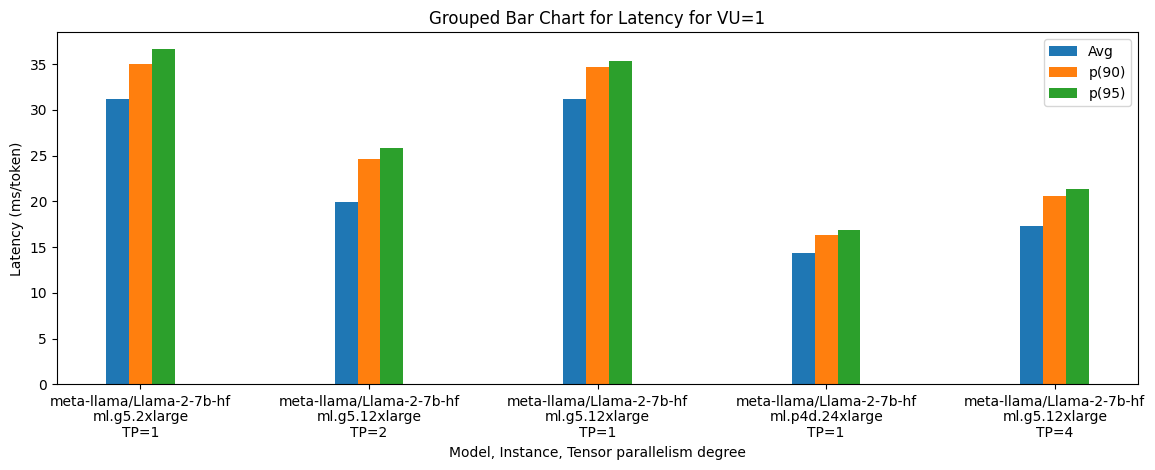

In [245]:
import pandas as pd
import matplotlib.pyplot as plt


# Plot the grouped bar chart
x_labels = [f"{model}\n{instance}\nTP={tp}" for model, instance, tp in zip(grouped_data['Model Id'],
                                                                       grouped_data['Instance'],
                                                                       grouped_data['Tensor parallelism degree'])]

x = range(len(grouped_data))
width = 0.1

plt.bar(x, grouped_data['Latency (ms/token) med'], width, label='Avg')
plt.bar([i + width for i in x], grouped_data['Latency (ms/token) p(90)'], width, label='p(90)')
plt.bar([i + 2 * width for i in x], grouped_data['Latency (ms/token) p(95)'], width, label='p(95)')

plt.xlabel('Model, Instance, Tensor parallelism degree')
plt.ylabel('Latency (ms/token)')
plt.title(f'Grouped Bar Chart for Latency for VU={vu}')
plt.xticks([i + width for i in x], x_labels)
plt.legend()
plt.tight_layout(rect=[0.1, 0, 2, 1])
plt.show()


#### Overall best Latency

To compare the best performing configuration for each model, we will use the overall best latency. This is the best latency achieved by each model across all configurations (instance, TP). You can use this to see what is the best possible latency i can achieve for a given model on a instance size configuration. 

In [184]:
# Sort the dataframe by "Latency (ms/token) min" in ascending order
ldf_sorted = ldf.sort_values(by='Latency (ms/token) med', ascending=True)

# Drop duplicates based on the columns "Model Id", "Instance" while keeping the first (lowest latency) occurrence
unique_groups_with_best_latency = ldf_sorted.drop_duplicates(subset=['Model Id', 'Instance'])

print(unique_groups_with_best_latency.to_markdown(index=False))

| Host      | Model Id                 | Instance        |   Virtual Users |   Tensor parallelism degree |   Latency (ms/token) avg |   Latency (ms/token) min |   Latency (ms/token) med |   Latency (ms/token) max |   Latency (ms/token) p(90) |   Latency (ms/token) p(95) |
|:----------|:-------------------------|:----------------|----------------:|----------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|---------------------------:|---------------------------:|
| sagemaker | meta-llama/Llama-2-7b-hf | ml.p4d.24xlarge |               1 |                           1 |                  15.455  |                  13.4399 |                  14.3924 |                  60.3234 |                    16.3311 |                    16.8196 |
| sagemaker | meta-llama/Llama-2-7b-hf | ml.g5.12xlarge  |               1 |                           4 |                  19.0332 |                  16.1313 |                  17.

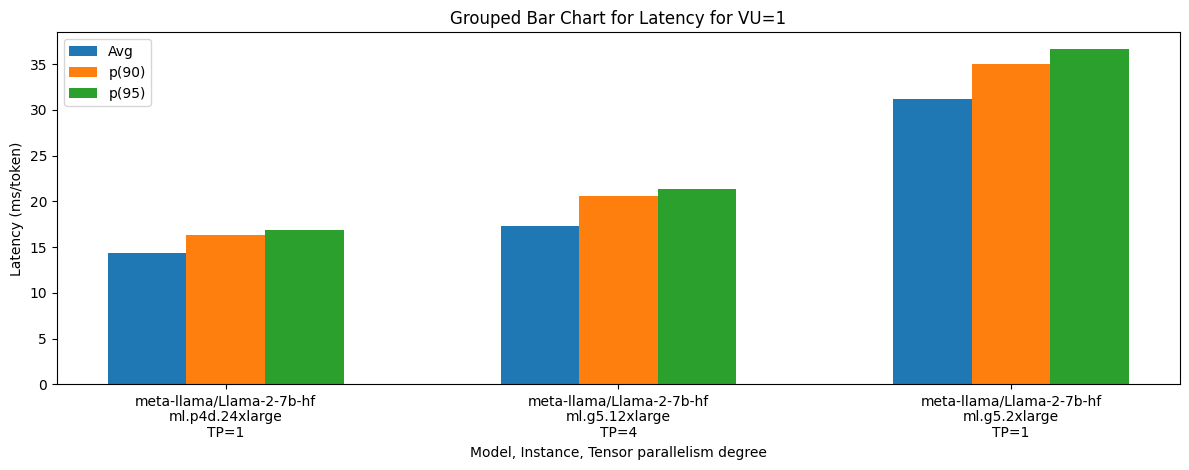

In [246]:
import pandas as pd
import matplotlib.pyplot as plt


# Plot the grouped bar chart
x_labels = [f"{model}\n{instance}\nTP={tp}" for model, instance, tp in zip(unique_groups_with_best_latency['Model Id'],
                                                                       unique_groups_with_best_latency['Instance'],
                                                                       unique_groups_with_best_latency['Tensor parallelism degree'])]

x = range(len(unique_groups_with_best_latency))
width = 0.2

plt.bar(x, unique_groups_with_best_latency['Latency (ms/token) med'], width, label='Avg')
plt.bar([i + width for i in x], unique_groups_with_best_latency['Latency (ms/token) p(90)'], width, label='p(90)')
plt.bar([i + 2 * width for i in x], unique_groups_with_best_latency['Latency (ms/token) p(95)'], width, label='p(95)')

plt.xlabel('Model, Instance, Tensor parallelism degree')
plt.ylabel('Latency (ms/token)')
plt.title(f'Grouped Bar Chart for Latency for VU={vu}')
plt.xticks([i + width for i in x], x_labels)
plt.legend()
plt.tight_layout(rect=[0.1, 0, 2, 1])
plt.show()


### Throughput

In our Benchmark throughput defines the number of tokens that can be processed per second. The higher the throughput the more tokens can be processed in a given time. The throughput is measured in tokens per second.


In [225]:
tdf = df[['Host', 'Model Id', 'Instance','Virtual Users' ,'Tensor parallelism degree','Latency (ms/token) med','Thorughput (tokens/second)']]

print(tdf.sort_values(by=['Thorughput (tokens/second)'], ascending=False).to_markdown(index=False))

| Host      | Model Id                 | Instance        |   Virtual Users |   Tensor parallelism degree |   Latency (ms/token) med |   Thorughput (tokens/second) |
|:----------|:-------------------------|:----------------|----------------:|----------------------------:|-------------------------:|-----------------------------:|
| sagemaker | meta-llama/Llama-2-7b-hf | ml.g5.12xlarge  |              20 |                           2 |                  66.4145 |                     295.198  |
| sagemaker | meta-llama/Llama-2-7b-hf | ml.g5.2xlarge   |              20 |                           1 |                  75.1437 |                     272.988  |
| sagemaker | meta-llama/Llama-2-7b-hf | ml.p4d.24xlarge |               5 |                           1 |                  18.763  |                     244.537  |
| sagemaker | meta-llama/Llama-2-7b-hf | ml.g5.12xlarge  |              10 |                           2 |                  41.1547 |                     224.908  |
| sagemake

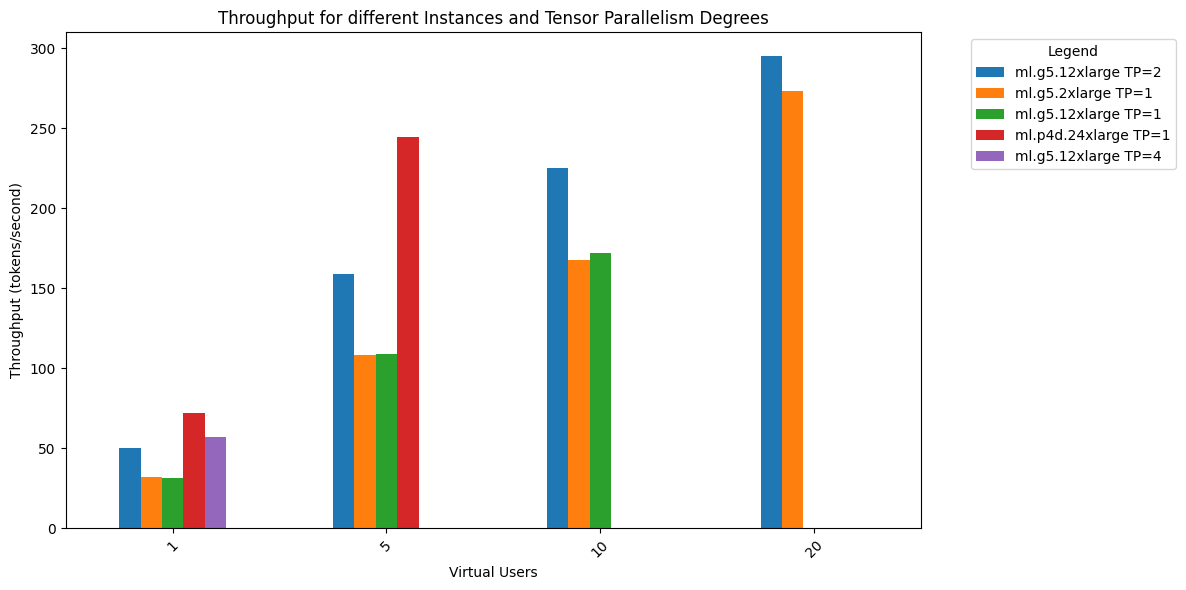

In [230]:
import pandas as pd
import matplotlib.pyplot as plt


# Pivot the data to create a table-like structure for easy plotting
pivot_table = tdf.pivot(index='Virtual Users', columns=['Instance', 'Tensor parallelism degree'], values='Thorughput (tokens/second)')

# Plot the throughput for each instance and tensor parallelism degree
ax = pivot_table.plot(kind='bar', rot=45, figsize=(12, 6))
plt.xlabel('Virtual Users')
plt.ylabel('Throughput (tokens/second)')
plt.title('Throughput for different Instances and Tensor Parallelism Degrees')
# Custom legend labels
legend_labels = [f"{i} TP={tp}" for i, tp in pivot_table.columns]
ax.legend(legend_labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
